# Self-driving car Nanodegree - Term 1

## Project 4: **Vehicle Detection** 
***

In this project, we created a vehicle detection and tracking pipeline with OpenCV, histogram of oriented gradients (HOG), and support vector machines (SVM), optimizing and evaluated the model on video data from a automotive camera taken during highway driving (start with the test_video.mp4 and later implement on full project_video.mp4).

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


Author : [Tran Ly Vu](https://github.com/tranlyvu)

- [Github repo](https://github.com/tranlyvu/autonomous-vehicle-projects/tree/master/Vehicle%20Detection)
- [Notebook](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Vehicle%20Detection/notebook/Vehicle_Dectection.ipynb)
- [Python code](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Vehicle%20Detection/src/vehicle_detection.py)

---
### Dataset

Dataset was provided by Udacity: Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) 

These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   

There is also recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data. However, for this project, I did not use this dataset

#### Importing packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from skimage import color, exposure
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from moviepy.editor import VideoFileClip 
from scipy.ndimage.measurements import label
from IPython.display import HTML
%matplotlib inline

#### Loading data

In [2]:
vehicles_images = glob.glob('../../../vehicles/vehicles/*/*.png')
non_vehicles_images = glob.glob('../../../non-vehicles/non-vehicles/*/*.png')

def load_data(my_list):
    new_list = []
    for image in my_list:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_list.append(img)
    return new_list

cars = load_data(vehicles_images)
non_cars = load_data(non_vehicles_images)
print('Number of car images: ', len(cars))
print('Number of non-car images: ', len(non_cars))

Number of car images:  8792
Number of non-car images:  8968


#### Plotting 10 random images and save 2 samples

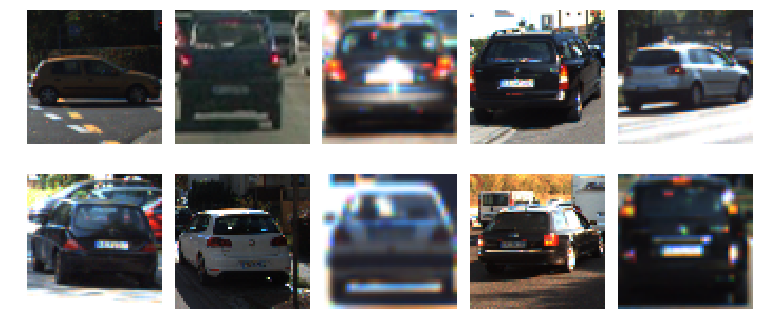

In [3]:
"""plotting 10 randome traffic sign images"""
def plot_10_random_images(images):
    fig, axes = plt.subplots(2, 5, figsize=(13, 6))
    fig.subplots_adjust(left=None, right=None, hspace = .02, wspace=0.1)
    for i in range(2):
        for j in range(5):
            randomindex = random.randint(0, len(images) - 1) 
            axes[i,j].axis('off')
            axes[i,j].imshow(images[randomindex])
            
plot_10_random_images(cars)

"""Saving 2 sample images"""
plt.imsave('../output_images/sample_car_img.jpg', cars[0])
plt.imsave('../output_images/sample_non_car_img.jpg', non_cars[0])

### Feature extraction

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


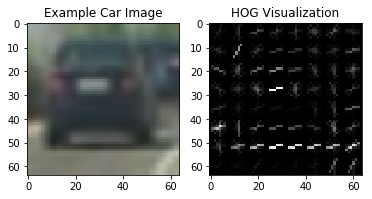

In [5]:
sample_car_gray = cv2.cvtColor(cars[0], cv2.COLOR_RGB2GRAY)
sample_non_car_gray = cv2.cvtColor(non_cars[0], cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features1, hog_image1 = get_hog_features(sample_car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
features2, hog_image2 = get_hog_features(sample_non_car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(cars[0], cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization')
plt.imsave('../output_images/sample_car_hog.jpg', hog_image1)

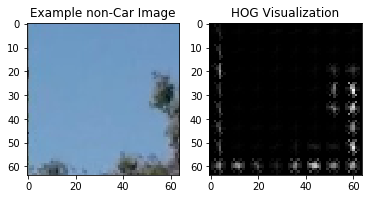

In [6]:
plt.subplot(121)
plt.imshow(non_cars[0], cmap='gray')
plt.title('Example non-Car Image')
plt.subplot(122)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')
plt.imsave('../output_images/sample_non_car_hog.jpg', hog_image2)

#### Parameter Tuning

I tried various combinations of parameters with trials and errors, I finaly chose to use spatial binning, color histogram and hog features with the following parameters

```
color space : 'YCrCb' 
the number of orientation bins:  9 
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = "ALL" 
spatial_size = (16, 16) 
hist_bins = 16   
```

In [7]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
            
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     color_space='RGB', 
                     spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2,
                     hog_channel=0,
                    spatial_feat=True, 
                     hist_feat=True, 
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)

#### Model Training
I trained a linear SVM using the above features and parameters. 

I initially used RGB for color space but 'YCrCb' yielded better result. Number of orientation bins is 9 as it is recommended by original HOG paper. SVM was first recommended by udacity and actually provided good result so i did not tried other models.

I was also normalizing the training data as recommended by Udacyty with sklearn.preprocessing.StandardScaler()

The final test accuracy was 0.99

In [8]:
"""Parameters"""
COLOR_SPACE = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ORIENTATION = 9  # HOG orientations
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 2 # HOG cells per block
HOG_CHANNEL = "ALL" # Can be 0, 1, 2, or "ALL"
SPATIAL_SIZE = (16, 16) # Spatial binning dimensions
HIST_BINS = 16    # Number of histogram bins
IS_SPATIAL_FEAT = True # Spatial features on or off
IS_HIST_FEAT = True # Histogram features on or off
IS_HOG_FEAT = True # HOG features on or off

t=time.time()
#n_samples =1000
#random_idxs = np.random.randint(0, len(cars), n_samples)
#test_cars = np.array(cars)[random_idxs]
#test_noncars = np.array(non_cars)[random_idxs]

car_features = extract_features(cars, 
                                color_space = COLOR_SPACE, 
                                spatial_size= SPATIAL_SIZE, 
                                hist_bins = HIST_BINS, 
                                orient = ORIENTATION, 
                                pix_per_cell = PIX_PER_CELL, 
                                cell_per_block = CELL_PER_BLOCK, 
                                hog_channel = HOG_CHANNEL,
                                spatial_feat = IS_SPATIAL_FEAT , 
                                hist_feat = IS_HIST_FEAT,
                                hog_feat = IS_HOG_FEAT)

notcar_features = extract_features(non_cars, 
                                color_space = COLOR_SPACE, 
                                spatial_size= SPATIAL_SIZE, 
                                hist_bins = HIST_BINS, 
                                orient = ORIENTATION, 
                                pix_per_cell = PIX_PER_CELL, 
                                cell_per_block = CELL_PER_BLOCK, 
                                hog_channel = HOG_CHANNEL,
                                spatial_feat = IS_SPATIAL_FEAT , 
                                hist_feat = IS_HIST_FEAT,
                                hog_feat = IS_HOG_FEAT)

print(time.time()-t, 'Seconds to compute features...')


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
SVC = LinearSVC()
# Check the training time for the SVC
SVC.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(SVC.score(X_test, y_test), 4))


90.3665885925293 Seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
119.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


#### Sliding Window Search

For searching cars in an input image I use sliding window technique that taught by Udacity. It means that I iterate over image area that could contain cars with approximately car sized box and try to classify whether box contain car or not.  I use  sliding window sizes of 96 pixels side size. While iterating I use 50% window overlapping in horizontal and vertical directions. I also decided to search random window positions at random scales from bottom half of the image. Here is a sample of test images:

In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient,
                                       pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel,
                                       spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, 
                                       hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

1516.1641855239868  seconds to process one image searching  150 windows


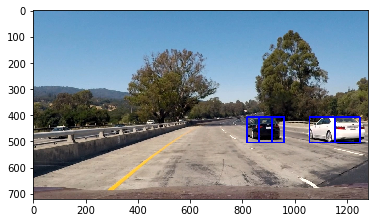

In [23]:
t1 = time.time()

img = mpimg.imread("../test_images/test1.jpg")
y_start_stop = [img.shape[0]//2, img.shape[0]] # Min and max in y to search in slide_window()
draw_image = np.copy(img)
windows = slide_window(img, 
                       x_start_stop = [None, None],
                       y_start_stop = y_start_stop, 
                        xy_window=(96, 96),
                       xy_overlap=(0.5, 0.5))

hot_windows = search_windows(img, 
                             windows, 
                             clf = SVC, 
                             scaler = X_scaler, 
                             color_space = COLOR_SPACE , 
                             spatial_size = SPATIAL_SIZE, 
                             hist_bins = HIST_BINS, 
                             orient = ORIENTATION , 
                             pix_per_cell = PIX_PER_CELL, 
                             cell_per_block = CELL_PER_BLOCK, 
                             hog_channel = HOG_CHANNEL, 
                             spatial_feat = IS_SPATIAL_FEAT, 
                             hist_feat = IS_HIST_FEAT, 
                             hog_feat = IS_HOG_FEAT )                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
print(time.time()-t, ' seconds to process one image searching ', len(windows), 'windows')
plt.imshow(window_img)
plt.imsave('../output_images/window_search.jpg', window_img)

#### All test images

In [11]:
example_images = glob.glob("../test_images/*.jpg")
images = []
titles = []

for img_src in example_images:
    t1 = time.time()
    
    img = mpimg.imread(img_src)
    draw_image = np.copy(img)
    y_start_stop = [img.shape[0]//2, img.shape[0]] # Min and max in y to search in slide_window()

    windows = slide_window(img, 
                           x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, 
                            xy_window=(96, 96), 
                           xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(img, 
                                 windows, 
                                 clf = SVC, 
                                 scaler = X_scaler, 
                                 color_space = COLOR_SPACE , 
                                 spatial_size = SPATIAL_SIZE, 
                                 hist_bins = HIST_BINS, 
                                 orient = ORIENTATION , 
                                 pix_per_cell = PIX_PER_CELL, 
                                 cell_per_block = CELL_PER_BLOCK, 
                                 hog_channel = HOG_CHANNEL, 
                                 spatial_feat = IS_SPATIAL_FEAT, 
                                 hist_feat = IS_HIST_FEAT, 
                                 hog_feat = IS_HOG_FEAT ) 
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    images.append(window_img)
    titles.append('')
    print(time.time()-t, ' seconds to process one image searching ', len(windows), 'windows')

fig = plt.figure(figsize = (12,18), dpi=300)
visualize(fig, 5, 2, images, titles)


123.43717360496521  seconds to process one image searching  150 windows
124.36652278900146  seconds to process one image searching  150 windows
125.25144410133362  seconds to process one image searching  150 windows
126.09180951118469  seconds to process one image searching  150 windows
127.19431853294373  seconds to process one image searching  150 windows
128.00149488449097  seconds to process one image searching  150 windows


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


#### Hog sub-sampling Window search

In [12]:
img_boxes = []
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heat_map[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
                
    return draw_img, heat_map

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
        

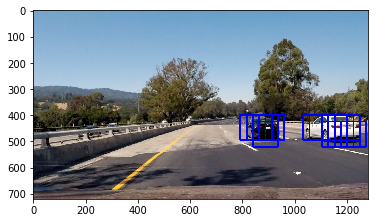

In [26]:
"""Parameters"""
COLOR_SPACE = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ORIENTATION = 9  # HOG orientations
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 2 # HOG cells per block
HOG_CHANNEL = "ALL" # Can be 0, 1, 2, or "ALL"
SPATIAL_SIZE = (16, 16) # Spatial binning dimensions
HIST_BINS = 16    # Number of histogram bins
IS_SPATIAL_FEAT = True # Spatial features on or off
IS_HIST_FEAT = True # Histogram features on or off
IS_HOG_FEAT = True # HOG features on or off
YSTART= 400
YSTOP = 656
SCALE = 1.5

img = mpimg.imread("../test_images/test4.jpg")   
out_img , heatmap = find_cars(img, 
                                  ystart=YSTART, 
                                  ystop=YSTOP,
                                  scale=SCALE, 
                                  svc = SVC, 
                                  X_scaler = X_scaler,
                                  orient= ORIENTATION, 
                                  pix_per_cell = PIX_PER_CELL,
                                  cell_per_block= CELL_PER_BLOCK, 
                                  spatial_size = SPATIAL_SIZE,
                                  hist_bins = HIST_BINS)
plt.imshow(out_img)
plt.imsave('../output_images/sample_heatmap.jpg', heatmap)


#### Eliminating False Positive

In order to eliminate overlapping detection and false positive, I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  


In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### Single test image

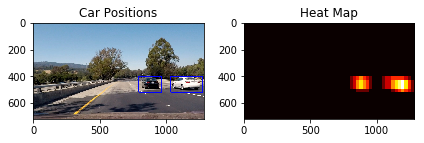

In [29]:
labels = label(heatmap)
#draw bouding box on cop of image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
plt.imsave('../output_images/sample_draw_img.jpg', draw_img)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

#### All test images

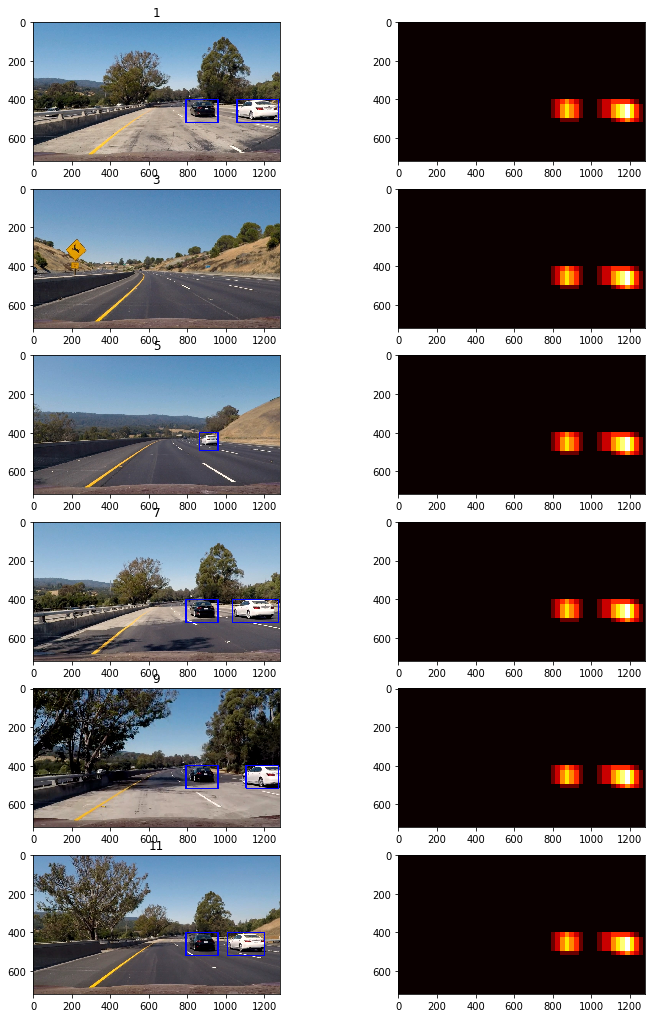

In [25]:
out_images = []
out_titles = []
for i, img_src in enumerate(example_images):
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, 
                      ystart=YSTART, 
                      ystop=YSTOP,
                      scale=SCALE, 
                      svc = SVC, 
                      X_scaler = X_scaler,
                      orient= ORIENTATION, 
                      pix_per_cell = PIX_PER_CELL,
                      cell_per_block= CELL_PER_BLOCK, 
                      spatial_size = SPATIAL_SIZE,
                      hist_bins = HIST_BINS)
    
    labels = label(heat_map)
    #draw bouding box on cop of image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    out_images.append(draw_img)
    out_titles.append('')
    out_images.append(heatmap)
    out_titles.append('')
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)
    

#### Video generation

In [20]:
def process_image(img):
    # Find final boxes from heatmap using label function
    out_img, heatmap = find_cars(img, 
                      ystart=YSTART, 
                      ystop=YSTOP,
                      scale=SCALE, 
                      svc = SVC, 
                      X_scaler = X_scaler,
                      orient= ORIENTATION, 
                      pix_per_cell = PIX_PER_CELL,
                      cell_per_block= CELL_PER_BLOCK, 
                      spatial_size = SPATIAL_SIZE,
                      hist_bins = HIST_BINS)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [21]:
clip1 = VideoFileClip('../project_video.mp4')
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

video_output = '../output_videos/project_video.mp4'
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/project_video.mp4
[MoviePy] Writing video ../output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [10:58<00:00,  2.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video.mp4 

Wall time: 11min


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(video_output))

#### Discussion

From my video, there are some redundant boxes although cars have been detected. Here are a few things I could consider doing if i were to have more times: 

```
- Try new classifier, i.e decision tree
- Try to use more data, i.e [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations)
- Doing more parameters tuning ,etc
```